### Customizing Layers and Models
- 사실 기존의 keras API를 사용하고 조절 가능한 hyperparameter만 조절해도 쉽게 딥러닝을 구현할 수 있다.
- 하지만 시각적으로 보았을 때 기존에 내가 하던 방법대로 모델을 설계하면 계속 직렬화된, 즉 Sequential model에 layer을 add해 나가는 방법은 별로 알아보기가 좋지 않아 보였다.
- 따라서 class를 이용해서, 혹은 class가 아니더라도 나중에 쉽게 수정및 변형이 가능한 방법으로 model을 설계하는 방법을 공부 해 보았고, 그 내용을 정리해 보았다.

**전부 공부를 해보고 느낀 점은 이렇게 class를 이용해서 model, layer, loss, metrics등을 모두 정의 할 수 있고 애초에 우리가 사용하고 있는 것들고 이러한 형태로 객체화 되어 있는 것이기 떄문에 어느 정도 정해진 틀과 사용해야 하는, 필수적으로 들어가야 하는 요소와 함수들이 존재함을 알았다. 전혀 백지 상태에서 짜는 것이 아닌 필수적인 들어가야 하는 요소들에 맞추어서 코드를 짜주면 어려움이 없을 것이다.**


- 그리고 DCGAN을 만들면서 간단한 generator이나 discriminator또한 만들어 보았는데 이는 그냥 __init__와 call()함수만 있으면 되기 때문에 만들기가 쉽다.  
- 모델을 class로 만들떄에 compile()함수등과 같은 것을 새롭게 만들고 train_step()을 새롭게 만들지 않는 이상 의외로 layer보다 간단하게 구현이 가능한 느낌이다.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

모델을 만들었으니 학습은 해 보아야 할텐데, 간단하게 MNIST데이터를 불러와서 시도해 보고자 한다.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#### 1. Using a Graph of Layers
- 간단한 심층 신경망 모델을 만들어 보자.

In [ ]:
inputs = tf.keras.Input(shape = (784,))
inputs.shape

TensorShape([None, 784])

In [ ]:
inputs.dtype

tf.float32

- 아래의 방법과 같이 모델을 만들때에 input값을 첫번째 layer에 넣어주고 계속 반복해서 **직접 연결**을 해 준 뒤에 마지막에 모델을 만들 때에는 한꺼번에 input과 output값만 입력하면 tf.keras.Model 모듈이 알아서 Sequential model을 만들어 준다.
    - 단 주의할 점은 이렇게 알아서 연결이 되는 것도 데이터의 크기나 모양등이 연결이 가능할 때 이기 때문에 제대로 layer을 설정해 주어야 한다.

In [ ]:
dense = tf.keras.layers.Dense(64, activation = 'relu')
x = dense(inputs)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


- 이제 위에서 다운 받은 MNIST 데이터로 학습을 진행해 보고자 하는데, 무엇보다 중요한 것은 모델을 만들때의 input 자료형이 float32이기 때문에 그렇게 되도록 바꾸어 주어야 한다.
- 그리고 이미지 데이터이다 보니 255.0으로 나누어 0과 1사이의 픽셀값으로 바꾸어 주어야 위에서 설정한 activation인 relu의 출력값의 범위와 일치하게 된다.

In [ ]:
train_images.dtype

dtype('uint8')

In [ ]:
test_images.shape

(10000, 784)

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 784).astype('float32')/255.0
test_images = test_images.reshape(test_images.shape[0], 784).astype('float32')/255.0

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'],optimizer = tf.keras.optimizers.RMSprop())

- SparseCategoricalCrossentropy를 사용할 때에 기본 default 값을 이용하게 되면 model은 label값이 확률로서 저장 되어 있을 것이라고 생각한다. 그러나 이 경우에는 그렇지 않고 logits의 값으로 저장이 되어 있기 때문에 사용하게 될 경우 from_logits = True로 바꾸어야 한다.

In [ ]:
model.fit(train_images, train_labels, validation_split = 0.3, batch_size = 64, epochs = 5)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 3s 70us/sample - loss: 1.8991 - accuracy: 0.5720 - val_loss: 1.8680 - val_accuracy: 0.5943
Epoch 2/5
42000/42000 [==============================] - 2s 52us/sample - loss: 1.8581 - accuracy: 0.6025 - val_loss: 1.8686 - val_accuracy: 0.5921
Epoch 3/5
42000/42000 [==============================] - 2s 52us/sample - loss: 1.8494 - accuracy: 0.6097 - val_loss: 1.8672 - val_accuracy: 0.5899
Epoch 4/5
42000/42000 [==============================] - 2s 52us/sample - loss: 1.8443 - accuracy: 0.6140 - val_loss: 1.8642 - val_accuracy: 0.5933
Epoch 5/5
42000/42000 [==============================] - 2s 52us/sample - loss: 1.8405 - accuracy: 0.6178 - val_loss: 1.8603 - val_accuracy: 0.5977


#### 2. 이번에는 간단하게 위와 같은 방법으로 AutoEncoder을 만들어 보자
- 사실 오토인코더는 원리가 정말 간단하다. 
    - 그냥 인코더 역할을 해주는 모델에 의해서 입력한 이미지에 대한 특징 추출을 해 주고, 이 데이터를 디코드 역할을 하는 모델에 넣는다 그렇게 되면 Conv2DTranspose라는 Conv2D의 반대의 역할을 해주는 층에 의해서 다시 이미지를 크게 확장 시켜 준다. 그렇게 해서 출력한 이미지는 1개일 것이고, 때문에 마지막 층의 filter의 개수는 1개이다

In [ ]:
encoder_input = tf.keras.Input(shape = (28,28,1))
x = tf.keras.layers.Conv2D(16,3,activation = 'relu')(encoder_input)
x = tf.keras.layers.Conv2D(32, 3, activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D(3)(x)
x = tf.keras.layers.Conv2D(32, 3, activation = 'relu')(x)
x = tf.keras.layers.Conv2D(16, 3, activation = 'relu')(x)
encoder_output = tf.keras.layers.GlobalMaxPool2D()(x)

encoder = tf.keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 16)                0   

In [ ]:
x = tf.keras.layers.Reshape((4,4,1))(encoder_output)
x = tf.keras.layers.Conv2DTranspose(16, 3, activation = 'relu')(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation = 'relu')(x)
x = tf.keras.layers.UpSampling2D(3)(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, activation = 'relu')(x)
decoder_output = tf.keras.layers.Conv2DTranspose(1,3, activation = 'relu')(x)

AutoEncoder = tf.keras.Model(encoder_input, decoder_output)
AutoEncoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 16)                0   

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images.astype('float32'), test_images.astype('float32')
train_images = tf.expand_dims(train_images, axis = -1)
test_images = tf.expand_dims(test_images, axis = -1)

In [ ]:
AutoEncoder.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
AutoEncoder.fit(train_images/255.0, train_images/255.0, epochs = 5, batch_size = 32)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 34s 567us/sample - loss: 0.0287 - accuracy: 0.5011- loss: 0.0289 - accu - ETA - ETA:  - E
Epoch 2/5
60000/60000 [==============================] - 49s 823us/sample - loss: 0.0254 - accuracy: 0.5025
Epoch 3/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0239 - accuracy: 0.5031
Epoch 4/5
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.0230 - accuracy: 0.5036
Epoch 5/5
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.0222 - accuracy: 0.5039


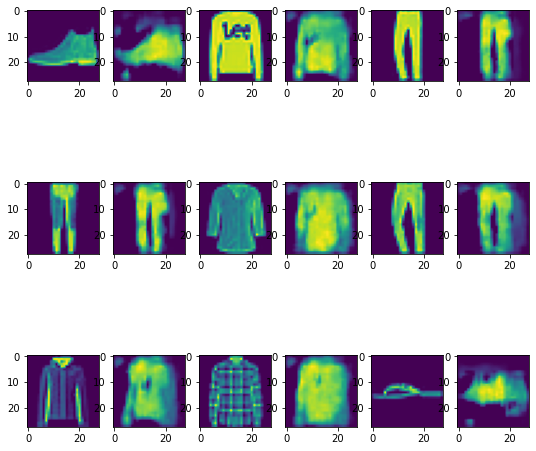

In [ ]:
plt.figure(figsize = (9,9))
y_pred = AutoEncoder.predict(test_images)
for i in range(9):
    plt.subplot(3,6,i*2+1)
    plt.imshow(test_images[i]*255.0)
    plt.subplot(3,6,i*2+2)
    plt.imshow(y_pred[i]*255.0)

- 아직 정확한 그림이 나오는 것은 아니지만 학습의 횟수를 높이면 훨씬 좋은 성과를 낼 수 있을 것이다.
- 그러나 지금 하는 공부는 모델 설계를 위한 다양한 방법을 익히기 위해서 이기 때문에 학습 시간에 많은 시간을 쏟기는 힘들었다.

#### 3. 지금까지는 하나의 input과 하나의 output을 가지는 학습을 진행했다면 이번에는 multiple input and output을 가지는 모델을 만들어 보고자 한다.
- 이는 Sequential API로는 만들 수 없는 형태의 model이다.
- 예를 들어서 우리가 고객 정보 여러개를 이용해서 고객의 수준이나 배정등을 해 주어야 한다고 할 때에 input data로 티켓의 이름, 제목, 그리고 다른 태그를 넣고 output data로는 binary data인 0/1, 그리고 softmax data인 배정 위치를 갖는다고 하자.
- 이때에는 반드시 사용자 정의 함수를 이용해야만 모델을 만들 수 있다.

In [ ]:
num_tag = 12      #총 제목의 종류의 개수 = 12개
num_words = 1000    #총 인식 가능한 단어 사전에 있는 단어의 개수 = 1000개
num_department = 4   #총 고객이 분류 가능한 장소의 개수 = 4개

title_input = tf.keras.Input(
    shape = (None, ), name = 'title'
)
body_input = tf.keras.Input(
    shape = (None, ), name = 'body'
)
tag_input = tf.keras.Input(
    shape = (num_tag, ), name = 'tag'
)

title_features = tf.keras.layers.Embedding(num_words, 64)(title_input)
body_features = tf.keras.layers.Embedding(num_words, 64)(body_input)
title_features = tf.keras.layers.LSTM(128)(title_features)
body_features = tf.keras.layers.LSTM(128)(body_features)

x = tf.keras.layers.concatenate([title_features, body_features, tag_input])

priority_pred = tf.keras.layers.Dense(1, name = 'priority')(x)
department_pred = tf.keras.layers.Dense(num_department,name = 'department')(x)

model = tf.keras.Model(
    inputs = [title_input, body_input, tag_input],
    outputs = [priority_pred, department_pred]
)


In [ ]:
model.compile(
    loss = {
        'priority' : tf.keras.losses.BinaryCrossentropy(from_logits= True),
        'department' : tf.keras.losses.CategoricalCrossentropy(from_logits = True)
    },
    optimizer = tf.keras.optimizers.RMSprop(1e-3),
    loss_weights = [1.0, 0.2],
    metrics = ['accuracy']
)

- ```np.random.randint()```는 min <= x < max 인 정수를 지정해준 size에 맞게 랜덤하게 생성해 준다.
- ```np.random.random()```는 0 <= x < 1.0인 실수를 지정해준 size에 맞게 랜덤하게 생성해 준다.
- ```np.random.randn()```는 표준 정규분포의 형태를 따르는 난수를 생성해 주는데, 표준 정규 분포를 따른다는 것은 일단 확률값이기 때문에 -1과 1 사이의 값이고 평균이 0, 표준편차가 1인 값이다.

In [ ]:
#그냥 랜덤하게 입력해볼 데이터를 만들어 보면
title_rand = np.random.randint(num_words, size = (1280, 10))
body_rand = np.random.randint(num_words, size = (1280, 100))
tag_rand = np.random.randint(2, size = (1280, num_tag)).astype('float32')

priority_rand = np.random.random(size = (1280, 1))
department_rand = np.random.randint(2, size = (1280, num_department))

In [ ]:
model.fit([title_rand, body_rand, tag_rand], [priority_rand, department_rand], epochs = 5, batch_size = 32)

Train on 1280 samples
Epoch 1/5
1280/1280 [==============================] - 4s 3ms/sample - loss: 1.2727 - priority_loss: 0.6994 - department_loss: 2.8667 - priority_accuracy: 0.0000e+00 - department_accuracy: 0.1891
Epoch 2/5
1280/1280 [==============================] - 1s 489us/sample - loss: 1.2665 - priority_loss: 0.6968 - department_loss: 2.8481 - priority_accuracy: 0.0000e+00 - department_accuracy: 0.1891
Epoch 3/5
1280/1280 [==============================] - 1s 486us/sample - loss: 1.2677 - priority_loss: 0.7000 - department_loss: 2.8382 - priority_accuracy: 0.0000e+00 - department_accuracy: 0.1914
Epoch 4/5
1280/1280 [==============================] - 1s 491us/sample - loss: 1.2643 - priority_loss: 0.6965 - department_loss: 2.8388 - priority_accuracy: 0.0000e+00 - department_accuracy: 0.1937
Epoch 5/5
1280/1280 [==============================] - 1s 492us/sample - loss: 1.2685 - priority_loss: 0.7005 - department_loss: 2.8401 - priority_accuracy: 0.0000e+00 - department_accurac

#### 4. Class 이용해서 Custom Layer만들기
- 사실 케라스는 우리가 찾을 법 한 거의 모든 데이터를 가지고 있다.
- 그러나 나중에 현업에서, 혹은 협업을 할 일이 생긴다면 class를 이용해서 모델을 만들고 알아보기 쉽도록 하는 것이 나을 것이라고 생각한다.
- 따라서 원래는 이 방법을 내가 찾는 것이 keras API에 없을 때에 사용하는데, 이번에는 그냥 연습 겸 만들어 보고자 한다.  
 
**간단하게 call 함수와 build (필수는 아님 __init__에 넣어도 됨) 함수만 있다면 layer을 custom 하는 것이 가능하다.**

- 우선 Dense layer을 하나 만들어 보자.

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units = 32, **kwargs):
        super(CustomDense, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape = (input_shape[-1], self.units),
            initializer = 'random_normal',
            trainable = True
        )
        self.b = self.add_weight(
            shape = (self.units,),
            initializer = 'random_normal',
            trainable = True
        )
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
inputs = tf.keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = tf.keras.Model(inputs, outputs)

- 간단한 모델을 하나 만들어 보았다.

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(64, activation = 'relu')
        self.hidden2 = tf.keras.layers.Dense(10, activation = 'softmax')
    
    def call(self, inputs):
        x = self.hidden1(inputs)
        return self.hidden2(x)

**행렬을 배웠으면 해서는 안되는 실수를 해버렸다. matmul()도 결국에는 행렬의 곱 연산인데 inputs와 가중치인 self.w의 순서를 바꾸어서 자꾸 잘못된 결과가 나왔다.**

- 이번에는 RNN custom layer을 만들어 보고자 한다.
- RNN에서 시퀀스 데이터가 작동하는 원리를 간단하게 정리해 보자.
  1. 초기 상태인 h(0)을 모두 0으로 설정하고 첫번째 timestep인 x(0)과 함께 하나의 순환 뉴런으로 전달한다
  2. 뉴런은 이 값의 가중치 합을 계산하고 activation 함수로 설정이 된 tanh함수를 적용해서 결과를 만들어 첫번째 y(1)를 출력한다.
  3. 이제 이 출력이 새로운 상태인 h(0)가 된다.
  4. 이 새로운 상태는 다음 입력값인 x(1)과 함께 동일한 순환 뉴런으로 전달이 된다.
  5. 이제 이 과정이 마지막 timestep에 도달할 때 까지 계속 반복이 된다.

In [ ]:
units = 32
timesteps = 10
input_dim = 5

inputs = tf.keras.Input((None, units))
x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

class CustomRNN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomRNN, self).__init__()
        self.units = units
        self.layer1 = tf.keras.layers.Dense(units = units, activation = 'tanh')
        self.layer2 = tf.keras.layers.Dense(units = units, activation = 'tanh')
        self.classifier = model
    
    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape = (inputs.shape[0], self.units))
        for i in range(inputs.shape[1]):
            x = inputs[:,i,:]
            h = self.layer1(x)
            y = h + self.layer2(state)
            outputs.append(y)
        features = tf.stack(outputs, axis = 1)
        print(features.shape)
        return self.classifier(features)

In [ ]:
rnn_model = CustomRNN()

In [ ]:
rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

#### 5. 마지막으로 DCGAN 모델을 class를 이용해서 만드는 것으로 마무리 하고자 한다.
- 항상 DCGAN모델의 경우에는 데이터를 너무 많이 차지해서 이번에는 간단하게 MNIST데이터를 이용해서 학습을 하고 결과를 확인한 뒤에, 마무리를 할 예정이다.
- DCGAN은 이전에도 많이 설명을 썼었지만 생성자인 generator과 판별자인 discriminator로 이루어져 있다.
- generator의 경우에는 noise data를 입력받아서 이미지를 생성하게 되고, discriminator의 경우에는 이미지를 label과 함께 입력 받았을 때 이를 판별하는 역할을 한다.
- 그리고 마지막에는 사용자 정의 훈련 함수를 만들어서 훈련을 시켜줄 예정이다.

In [2]:
from tensorflow.keras.layers import LeakyReLU
leakyrelu = LeakyReLU(alpha = 0.2)

In [3]:
class Generator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Generator, self).__init__()
        self.first_layer = tf.keras.layers.Dense((7*7*128), activation = leakyrelu)
        self.main_layers = [
            tf.keras.layers.Reshape((7,7,128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same', activation = leakyrelu),
            tf.keras.layers.Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = 'same', activation = leakyrelu),
            tf.keras.layers.Conv2D(1, kernel_size = 7, padding = 'same', activation = 'tanh')
        ]
    def call(self, inputs):
        x = self.first_layer(inputs)
        for layer in self.main_layers:
            x = layer(x)
        return x

In [4]:
class Discriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__()
        self.first_layer = tf.keras.layers.Conv2D(64, kernel_size = 3, strides = 2, padding = 'same', activation = leakyrelu)
        self.main_layers = [
            tf.keras.layers.Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', activation = leakyrelu),
            tf.keras.layers.GlobalMaxPool2D(),
            tf.keras.layers.Dense(1)
        ]
    def call(self, inputs):
        x = self.first_layer(inputs)
        for layer in self.main_layers:
            x = layer(x)
        return x

In [5]:
generator = Generator()
discriminator = Discriminator()

- 밑의 model에서 train_step을 정의 해 준것은 실제로 나중에 학습을 시작하기 위해서 model.fit()을 하는 것을 overriding 해 준 것이다.
- 원래 fit()을 하는 것이 train_step(self, data)로 정의가 되기 때문이다.
  - 아래의 경우에는 compile까자 직접정의를 한 것이지만 그렇게 하지 않았다면 직접 compile을 함으로서 얻게 되는 정보인 loss와 metrics데이터를 불러서 갱신해야 한다.
  - loss는 ```loss = self.compiled_loss(y, y_predict)```
  - metrics는 ```self.compiled_metrics.update_state(y, y_predict)```이런 식으로 값을 얻고 이용한다.
  - 이 값들은 GradientTape()를 이용해서 loss를 trainable_variables를 이용해서 미분값을 계산해 ```optimizer.apply_gradients(zip(gradients, self.trainable_variables))```이런 식으로 가중치를 갱신하도록 한다.

In [100]:
class DCGAN(tf.keras.Model):
    #latent_dim이란 압축된 데이터의 크기로, 처음에 입력받게 될 압축된 랜덤한 시각 데이터의 공간의 크기이다.
    def __init__(self, discriminator, generator,loss_fn,latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.loss_fn = loss_fn
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        #튜플의 형태일 때에는 real_image와 가짜 이미지가 묶여 있는 형태이기 때문에 첫번쨰 데이터 사용
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape = (batch_size, self.latent_dim))
        
        #discriminator 학습
        #새로운 이미지를 generator을 이용해서 생성한다.
        generated_img = self.generator(random_noise)
        combined_img = tf.concat([generated_img, real_images],axis = 0)
        y_label = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis = 0)
        
        #label에 random noise를 추가해서 학습의 효율을 더 높여준다.
        y_label += 0.05 * tf.random.uniform(tf.shape(y_label))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_img)
            d_loss = self.loss_fn(y_label, predictions)
        
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
        
        
        #generator 학습
        random_noise = tf.random.normal(shape = (batch_size, self.latent_dim))
        wrong_label = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_noise))
            g_loss = self.loss_fn(wrong_label, predictions)
        
        #generator은 올바르지 않은 label이 붙은 것으로 예측한 discriminator의 loss정보를 이용해서 학습을 한다.
        gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))
        
        display.clear_output(wait=True)
        #plot_multiple(generated_img)
        return {"d_loss" : d_loss, "g_loss" : g_loss}
      
        
        
        
    

In [101]:
(x_train,_), (x_test,_) = tf.keras.datasets.fashion_mnist.load_data()

In [192]:
x_train.shape

(60000, 28, 28)

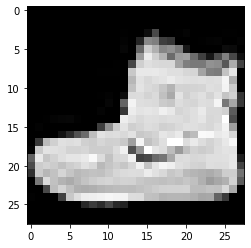

In [126]:
plt.imshow(x_train[0],cmap = 'gray')

In [199]:
BUFFER_SIZE, BATCH_SIZE = 1024, 128
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype('float32')/255.0
all_digits = (all_digits-0.5)*2
all_digits = np.reshape(all_digits, (-1,28,28,1))
all_digits = tf.data.Dataset.from_tensor_slices(all_digits)
all_digits = all_digits.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [200]:
all_digits

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [201]:
latent_dim = 128
dcgan = DCGAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim,loss_fn= tf.keras.losses.BinaryCrossentropy(from_logits=True))


In [202]:
dcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)
)

In [ ]:
dcgan.fit(all_digits, epochs = 5)

descriminator의 오차인 d_loss는 증가할 수록(그만킁 generator이 진짜에 가까운 이미지를 생성하고 있다는 의미이므로), generator의 오차인 g_loss는 감소할 수록 좋다.

In [221]:
random_noise = tf.random.normal(shape = (BATCH_SIZE, latent_dim))

In [222]:
pred = generator(random_noise)

In [223]:
tf.shape(pred)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([128,  28,  28,   1], dtype=int32)>

In [224]:
import IPython.display as display
def plot_multiple(img):
  plt.figure(figsize = (15,12))
  count = 0
  for index, image in enumerate(img):
      if index % 3 == 0 and count <= 31:
          plt.subplot(4,8,count + 1)
          count += 1
          image = np.reshape(image, (28,28))
          plt.imshow(np.asarray(image)/2+0.5, cmap = 'gray')
          plt.axis = 'off'
  plt.show()

계속 이미지 출력이 안되어서 답답했었는데 알고 보니 이미지를 출력할 수 있도록 하는 shape의 형태는 (가로, 세로)였고 **channel_size는 shape에 있으면 출력이 불가**했다.
- 사실 이게 당연한 이유는 우리가 2D평면에 이미지를 나타내는 것인데 channel_size의 정보까지 존재하게 되면 3D이기 때문이다.

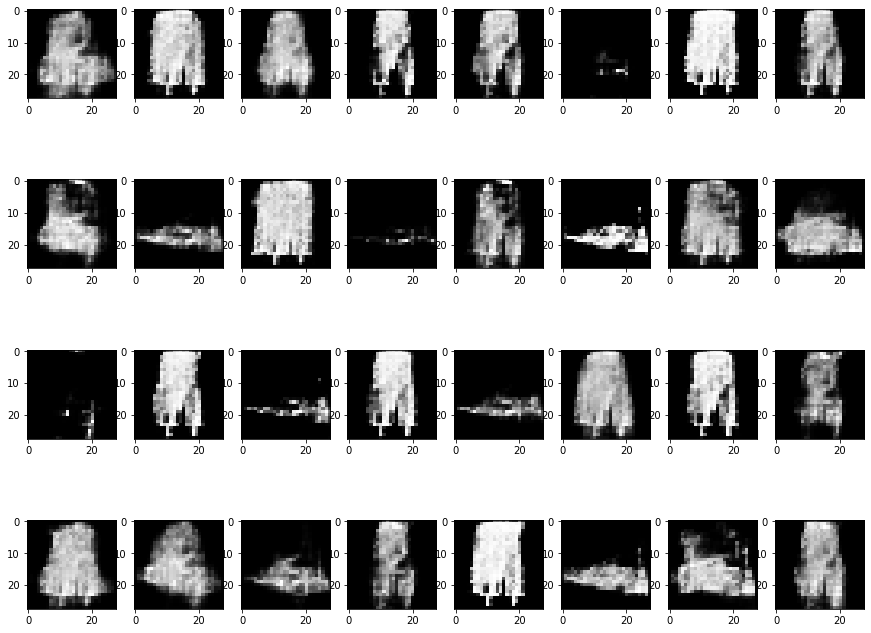

In [225]:
plot_multiple(pred)

**마지막에 출력한 그림을 보면 어느 정도 옷의 형태가 나오는 듯 하다. 물론 학습의 횟수를 10번만 했기 떄문에 만족스럽지는 않지만 그래도 30번 정도 더 하면 정말 비슷하게, d_loss가 1에 가깝게 나올 수도 있지 않을 까 싶다. 마지막으로 한 d_loss는 0.6정도 였다.**